In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt


Load MNIST & Convert to NumPy


In [2]:
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 15.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.12MB/s]


In [3]:
val_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)


In [4]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True
)


In [5]:
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False
)


One-Hot Encoding

In [6]:
def one_hot(labels, num_classes=10):
    return np.eye(num_classes)[labels]


Activation Functions

In [7]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def tanh(z):
    return np.tanh(z)

def tanh_derivative(z):
    return 1 - np.tanh(z)**2


Softmax (Output Layer)

In [8]:
def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


Neural Network Class

In [9]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activation='relu', lr=0.01):
        self.layer_sizes = layer_sizes
        self.lr = lr
        self.weights = {}
        self.biases = {}
        self.z = {}
        self.a = {}

        if activation == 'relu':
            self.activation = relu
            self.activation_derivative = relu_derivative
        elif activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_derivative = tanh_derivative
        else:
            raise ValueError("Unsupported activation")

        # Initialize parameters
        for i in range(len(layer_sizes) - 1):
            self.weights[i] = np.random.randn(
                layer_sizes[i], layer_sizes[i + 1]
            ) * 0.01
            self.biases[i] = np.zeros((1, layer_sizes[i + 1]))


    # Forward Propagation
    def forward(self, X):
        self.a[0] = X

        for i in range(len(self.layer_sizes) - 2):
            self.z[i + 1] = np.dot(self.a[i], self.weights[i]) + self.biases[i]
            self.a[i + 1] = self.activation(self.z[i + 1])

        # Output layer
        z_out = np.dot(self.a[len(self.layer_sizes) - 2],
                       self.weights[len(self.layer_sizes) - 2]) + \
                self.biases[len(self.layer_sizes) - 2]

        self.a[len(self.layer_sizes) - 1] = softmax(z_out)
        return self.a[len(self.layer_sizes) - 1]

    def compute_loss(self, y_true, y_pred):
        eps = 1e-8
        return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1))

    # Backward Propagation
    def backward(self, y_true):
        grads_w = {}
        grads_b = {}

        L = len(self.layer_sizes) - 1
        delta = self.a[L] - y_true

        for i in reversed(range(L)):
            grads_w[i] = np.dot(self.a[i].T, delta) / y_true.shape[0]
            grads_b[i] = np.mean(delta, axis=0, keepdims=True)

            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * \
                        self.activation_derivative(self.z[i])

        return grads_w, grads_b

    # Update Parameters
    def update_parameters(self, grads_w, grads_b):
        for i in self.weights:
            self.weights[i] -= self.lr * grads_w[i]
            self.biases[i] -= self.lr * grads_b[i]

    # Prediction & Evaluation
    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def evaluate(self, X, y):
        preds = self.predict(X)
        return np.mean(preds == y)



Model Training

In [10]:
def train_model(model, train_loader, val_loader, epochs=10):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        train_losses = []
        train_accs = []

        for images, labels in train_loader:
            images = images.cpu().numpy()
            labels = labels.cpu().numpy()

            X = images.reshape(images.shape[0], -1)
            y = one_hot(labels)

            preds = model.forward(X)
            loss = model.compute_loss(y, preds)

            grads_w, grads_b = model.backward(y)
            model.update_parameters(grads_w, grads_b)

            train_losses.append(loss)
            train_accs.append(model.evaluate(X, labels))

        # Validation
        val_losses = []
        val_accs = []

        for images, labels in val_loader:
            images = images.cpu().numpy()
            labels = labels.cpu().numpy()

            X = images.reshape(images.shape[0], -1)
            y = one_hot(labels)

            preds = model.forward(X)
            val_losses.append(model.compute_loss(y, preds))
            val_accs.append(model.evaluate(X, labels))

        history['train_loss'].append(np.mean(train_losses))
        history['train_acc'].append(np.mean(train_accs))
        history['val_loss'].append(np.mean(val_losses))
        history['val_acc'].append(np.mean(val_accs))

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Acc: {history['train_acc'][-1]:.4f} | "
              f"Val Acc: {history['val_acc'][-1]:.4f}")

    return history


In [11]:
experiments = [
    {
        "name": "relu_1",
        "layers": [784, 128, 10],
        "activation": "relu",
        "lr": 0.1
    },
    {
        "name": "relu_2",
        "layers": [784, 128, 64, 10],
        "activation": "relu",
        "lr": 0.1
    },
    {
        "name": "sigmoid",
        "layers": [784, 128, 64, 10],
        "activation": "sigmoid",
        "lr": 0.1
    },
    {
        "name": "tanh",
        "layers": [784, 128, 64, 10],
        "activation": "tanh",
        "lr": 0.1
    }
]


Save Plots


In [12]:
import csv
import os

os.makedirs("results", exist_ok=True)
os.makedirs("plots", exist_ok=True)

results = []

for exp in experiments:
    print(f"\nRunning Experiment: {exp['name']}")

    model = NeuralNetwork(
        layer_sizes=exp["layers"],
        activation=exp["activation"],
        lr=exp["lr"]
    )

    history = train_model(
        model,
        train_loader,
        val_loader,
        epochs=10
    )

    # Save final metrics
    results.append({
        "Experiment": exp["name"],
        "Layers": exp["layers"],
        "Activation": exp["activation"],
        "Learning Rate": exp["lr"],
        "Final Train Acc": history["train_acc"][-1],
        "Final Val Acc": history["val_acc"][-1],
        "Final Train Loss": history["train_loss"][-1],
        "Final Val Loss": history["val_loss"][-1]
    })

    # Plot accuracy
    plt.figure()
    plt.plot(history["train_acc"], label="Train Accuracy")
    plt.plot(history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(exp["name"])
    plt.legend()
    plt.savefig(f"plots/{exp['name']}_accuracy.png")
    plt.close()

    # Plot loss
    plt.figure()
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(exp["name"])
    plt.legend()
    plt.savefig(f"plots/{exp['name']}_loss.png")
    plt.close()



Running Experiment: relu_1
Epoch 1/10 | Train Acc: 0.8758 | Val Acc: 0.9131
Epoch 2/10 | Train Acc: 0.9472 | Val Acc: 0.9426
Epoch 3/10 | Train Acc: 0.9636 | Val Acc: 0.9519
Epoch 4/10 | Train Acc: 0.9732 | Val Acc: 0.9585
Epoch 5/10 | Train Acc: 0.9793 | Val Acc: 0.9652
Epoch 6/10 | Train Acc: 0.9835 | Val Acc: 0.9688
Epoch 7/10 | Train Acc: 0.9870 | Val Acc: 0.9716
Epoch 8/10 | Train Acc: 0.9893 | Val Acc: 0.9728
Epoch 9/10 | Train Acc: 0.9912 | Val Acc: 0.9748
Epoch 10/10 | Train Acc: 0.9928 | Val Acc: 0.9747

Running Experiment: relu_2
Epoch 1/10 | Train Acc: 0.5651 | Val Acc: 0.8804
Epoch 2/10 | Train Acc: 0.9488 | Val Acc: 0.9425
Epoch 3/10 | Train Acc: 0.9770 | Val Acc: 0.9561
Epoch 4/10 | Train Acc: 0.9872 | Val Acc: 0.9636
Epoch 5/10 | Train Acc: 0.9920 | Val Acc: 0.9701
Epoch 6/10 | Train Acc: 0.9949 | Val Acc: 0.9663
Epoch 7/10 | Train Acc: 0.9961 | Val Acc: 0.9725
Epoch 8/10 | Train Acc: 0.9973 | Val Acc: 0.9727
Epoch 9/10 | Train Acc: 0.9979 | Val Acc: 0.9752
Epoch 10/10 

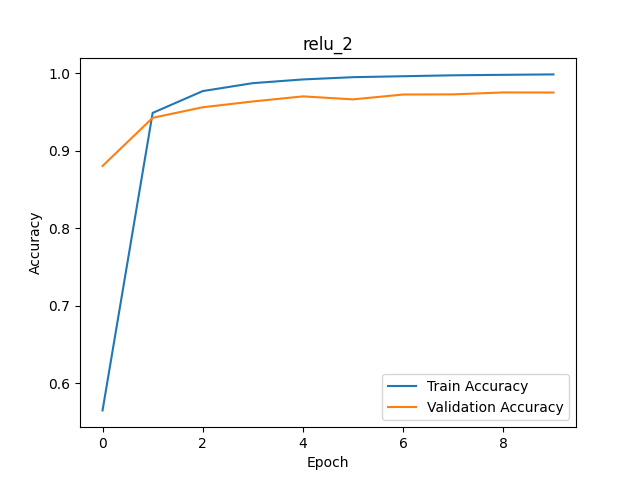

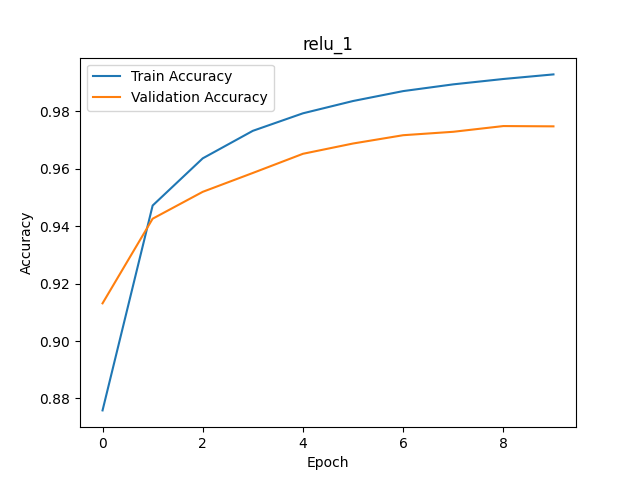

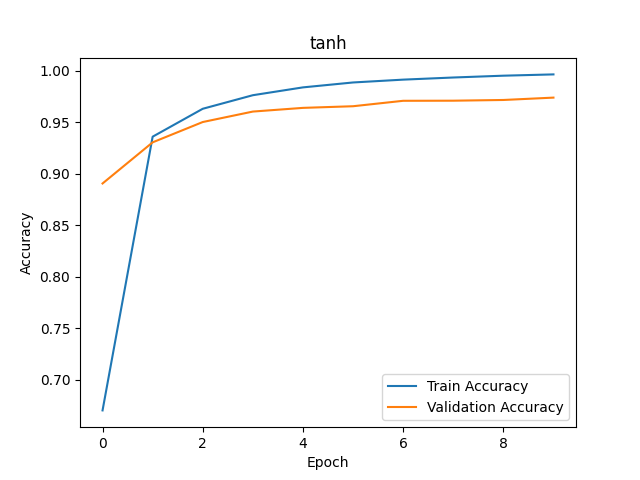

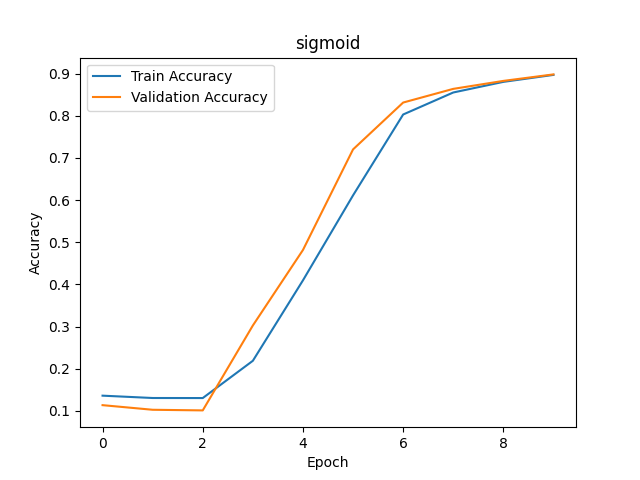

In [13]:
import os
from IPython.display import Image, display

for file in os.listdir("plots"):
    if "accuracy" in file:
        display(Image(filename=f"plots/{file}"))
